# 3D CNN over 11x11 single-station-sub-rasters, training one network per station
** Features: Precipitation, Mean-Air-Temperature **

Ausgabe: Veränderung Messstand 4 Wochen nach letztem Messstand zu letztem Messstand

Eingabe:
- 11x11 (ca. 11kx11km) Raster wöchentlich summierter Niederschlag für 8 Wochen vor letztem Messstand und vorhergesagter für die 4 Wochen nach letztem Messstand
- 11x11 monatl. Durchschnittstemperatur für die 3 vorkommenden Monate
- letzter Messstand und Messstand 4 Wochen davor, jeweils als Veränderung zu 4 Wochen davor

In [1]:
import numpy as np
import pandas as pd
import rasterio as rio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
import datetime
import random


%load_ext tensorboard

In [2]:
data_drive = r'F:/'

## 1. load Data

In [3]:
stammdaten = pd.read_excel(data_drive +r'GruV-Net/data/Stammdaten_HE.xlsx')
stammdaten.set_index('Proj_ID', inplace=True)
gw_weekly = pd.read_csv(data_drive +r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/gw_lvl_complete.csv')
gw_weekly.set_index('Datum', inplace=True)

In [4]:
rws_folder = data_drive + r'GruV-Net/data/precipitation/weekly-sum/GTiff/'

rws_files = glob.glob(rws_folder+'*2008*.tif') + glob.glob(rws_folder+'*2009*.tif') + glob.glob(rws_folder+'*2010*.tif') + glob.glob(rws_folder+'*2011*.tif') + glob.glob(rws_folder+'*2012*.tif') +glob.glob(rws_folder+'*2013*.tif') + glob.glob(rws_folder+'*2014*.tif') + glob.glob(rws_folder+'*2015*.tif') + glob.glob(rws_folder+'*2016*.tif') + glob.glob(rws_folder+'*2017*.tif')
rws_files.sort()
temp_folder = data_drive + r'GruV-Net/data/temperature/GTiff/'

In [5]:
def assemble_instances(regnie_files, temp_path, s):
    x_regnie = []
    x_temp = []
    x_gw = []
    y = []
    instances_list = []

    regnie_file_names = list(map(os.path.basename, regnie_files))

    for i in range(0, len(regnie_files)-11):
        regnie_srcs =  []
        for l in range(0,12):
            #print(regnie_files[i+l])
            regnie_srcs.append(rio.open(regnie_files[i+l]))
        temp_srcs = []
        for l in (2, 6, 10):
            #Monatsauswahl noch tricky
            #print(temp_path+'TAMM_'+ regnie_file_names[i+l][9:11]+'_'+regnie_file_names[i+l][4:8]+'_01.tif')
            temp_srcs.append(rio.open(temp_path+'TAMM_'+ regnie_file_names[i+l][9:11]+'_'+regnie_file_names[i+l][4:8]+'_01.tif'))

        instance_desc = []
        instance_desc.append(s)
        east = stammdaten.loc[s]['OSTWERT']
        north = stammdaten.loc[s]['NORDWERT']
        row, col = regnie_srcs[0].index(east, north)

        instance_regnie = np.ndarray(shape=(12))
        # das ist noch ein Problem, manche Stationen zu nah am Rand
        try:
            for j in range(12):
                r = regnie_srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                instance_regnie[j] = r.mean()
                instance_desc.append(regnie_srcs[j].name[48:-4])
        except ValueError:
            continue

        instance_temp = np.ndarray(shape=(3))
        try:
            for j in range(3):
                r = temp_srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                instance_temp[j] = r.mean()
                instance_desc.append(temp_srcs[j].name[35:-4])
        except ValueError:
            continue

        instance_gw = []
        try:    
            for k in [0, 4, 8]:
                #lieber in Prozent?
                change =  gw_weekly.loc[regnie_file_names[i+k+4][4:14], : ][s] - gw_weekly.loc[regnie_file_names[i+k][4:14], : ][s]
                if np.isnan(change):
                    raise Exception()
                else: 
                    instance_gw = np.append(instance_gw, change)
                    instance_desc.append(regnie_file_names[i+k+4][4:14])
                    instance_desc.append(change)
        except Exception:
            continue 

        x_regnie.append(instance_regnie)
        x_temp.append(instance_temp)
        x_gw.append(instance_gw[:2])
        instances_list.append(instance_desc)
        y = y + list(instance_gw[2:])
    return np.array(x_regnie), np.array(x_temp), np.array(x_gw), np.array(y), instances_list

## 2. Define and train CNN

In [6]:
regnie_input = keras.Input(shape=(12), name="regnie")
temp_input = keras.Input(shape=(3), name="temp")
gw_input = keras.Input(shape=(2), name="gw")

x = layers.concatenate([regnie_input, temp_input, gw_input])
x = layers.Dense(64)(x)
x = layers.Dense(32)(x)
pred = layers.Dense(1)(x)

GruV = keras.Model(
    inputs=[regnie_input, temp_input, gw_input],
    outputs=[pred],
)

In [7]:
GruV.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])
GruV.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
regnie (InputLayer)             [(None, 12)]         0                                            
__________________________________________________________________________________________________
temp (InputLayer)               [(None, 3)]          0                                            
__________________________________________________________________________________________________
gw (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 17)           0           regnie[0][0]                     
                                                                 temp[0][0]                   

In [8]:
#find 100 stations with most training examples
instance_list = pd.read_csv(r'F:/GruV-Net/data/assembled_instances/xgboost/xgboost_instances_prc-temp_2008-2017_wo-worst_List.csv').to_numpy()[:, 1:2].flatten()
from collections import Counter
best_stations = [i[0] for i in Counter(instance_list).most_common(100)]

In [9]:
hist = []
#cv_round = 1

for s in best_stations:
    X_regnie, X_temp, X_gw, y, _ = assemble_instances(rws_files, temp_folder, s)

    for train_idx, test_idx in TimeSeriesSplit(5).split(X_regnie):
        X_regnie_train, X_regnie_test = X_regnie[train_idx], X_regnie[test_idx]
        X_temp_train, X_temp_test = X_temp[train_idx], X_temp[test_idx]
        X_gw_train, X_gw_test = X_gw[train_idx], X_gw[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        regnie_scaler = preprocessing.StandardScaler().fit(X_regnie_train)
        temp_scaler = preprocessing.StandardScaler().fit(X_temp_train)
        gw_scaler = preprocessing.MaxAbsScaler().fit(X_gw_train)

        X_regnie_train = regnie_scaler.transform(X_regnie_train)
        X_regnie_test = regnie_scaler.transform(X_regnie_test)
        X_temp_train = temp_scaler.transform(X_temp_train)
        X_temp_test = temp_scaler.transform(X_temp_test)
        X_gw_train = gw_scaler.transform(X_gw_train)
        X_gw_test = gw_scaler.transform(X_gw_test)

        h = GruV.fit(
        {"regnie": X_regnie_train, "temp": X_temp_train, "gw": X_gw_train},
        y_train,
        epochs=20,
        validation_data=({"regnie": X_regnie_test, "temp": X_temp_test, "gw": X_gw_test}, y_test),
        )

        hist.append(h)



0.2028 - val_loss: 0.0778 - val_mean_absolute_error: 0.2151 - val_root_mean_squared_error: 0.2789
Epoch 19/20
54/54 [==============================] - 0s 499us/sample - loss: 0.0409 - mean_absolute_error: 0.1699 - root_mean_squared_error: 0.2023 - val_loss: 0.0785 - val_mean_absolute_error: 0.2162 - val_root_mean_squared_error: 0.2802
Epoch 20/20
54/54 [==============================] - 0s 481us/sample - loss: 0.0410 - mean_absolute_error: 0.1699 - root_mean_squared_error: 0.2026 - val_loss: 0.0787 - val_mean_absolute_error: 0.2167 - val_root_mean_squared_error: 0.2805
Train on 103 samples, validate on 49 samples
Epoch 1/20
103/103 [==============================] - 0s 369us/sample - loss: 0.0579 - mean_absolute_error: 0.1902 - root_mean_squared_error: 0.2405 - val_loss: 0.0599 - val_mean_absolute_error: 0.1820 - val_root_mean_squared_error: 0.2447
Epoch 2/20
103/103 [==============================] - 0s 349us/sample - loss: 0.0540 - mean_absolute_error: 0.1852 - root_mean_squared_erro

In [10]:
for i in range(len(hist)):
    hist_df = pd.DataFrame(hist[i].history) 

    # save to json:  
    hist_json_file = r'F:/GruV-Net/data/training_hists/2020-08-09_hist_1cnn-per-station_raster-mean/run'+ str(i) +'.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)


In [4]:
hist = [0]*500
for i in range(500):

    # save to json:  
    hist_json_file = r'F:/GruV-Net/data/training_hists/2020-08-09_hist_1cnn-per-station_raster-mean/run'+ str(i) +'.json'
    with open(hist_json_file, mode='r') as f:
        hist[i] = pd.read_json(f)


In [7]:
hist[0]

loss  mean_absolute_error  root_mean_squared_error  val_loss  \
0   2.157666             1.116750                 1.468899  2.947293   
1   1.447195             0.900649                 1.202994  2.341693   
2   0.983344             0.736611                 0.991637  1.877678   
3   0.665597             0.623086                 0.815841  1.550571   
4   0.533762             0.578396                 0.730590  1.305973   
5   0.410723             0.519186                 0.640877  1.118666   
6   0.330058             0.464117                 0.574507  0.957616   
7   0.257918             0.400500                 0.507857  0.810384   
8   0.204143             0.343331                 0.451822  0.676034   
9   0.152770             0.298483                 0.390858  0.557338   
10  0.118470             0.271328                 0.344194  0.449424   
11  0.094759             0.253940                 0.307829  0.356507   
12  0.073171             0.223689                 0.270501  0.274110   
13  0.058251             0.196017                 0.241353  0.205855   
14  0.045676             0.172453                 0.213720  0.149533   
15  0.035400             0.153019                 0.188150  0.105422   
16  0.025818             0.129672                 0.160680  0.072957   
17  0.020132             0.112313                 0.141888  0.050704   
18  0.017003             0.102757                 0.130396  0.036065   
19  0.015590             0.096800                 0.124862  0.026877   

    val_mean_absolute_error  val_root_mean_squared_error  
0                  1.463975                     1.716768  
1                  1.284514                     1.530259  
2                  1.143475                     1.370284  
3                  1.039688                     1.245219  
4                  0.959838                     1.142792  
5                  0.898647                     1.057670  
6                  0.833100                     0.978579  
7                  0.763121                     0.900214  
8                  0.691371                     0.822213  
9                  0.628605                     0.746551  
10                 0.562599                     0.670391  
11                 0.497325                     0.597082  
12                 0.434233                     0.523556  
13                 0.377789                     0.453713  
14                 0.323243                     0.386695  
15                 0.270922                     0.324687  
16                 0.222386                     0.270105  
17                 0.183683                     0.225175  
18                 0.153830                     0.189907  
19                 0.132132                     0.163943

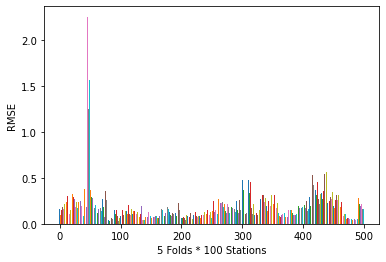

In [10]:
for i in range(500):
    plt.bar(i, hist[i]['val_root_mean_squared_error'][19])
plt.ylabel('RMSE')
plt.xlabel('5 Folds * 100 Stations')
plt.show()

In [11]:
rmse_s = [hist[i]['val_root_mean_squared_error'][19] for i in range(len(hist))]

In [13]:
np.save(r'F:/GruV-Net/data/training_hists/2020-08-09_hist_1cnn-per-station_raster-mean/rmse_all.npy', rmse_s)

In [9]:
rmse_s = np.load(r'F:/GruV-Net/data/training_hists/2020-08-09_hist_1cnn-per-station_raster-mean/rmse_all.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'F:/GruV-Net/data/training_hists/2020-08-09_hist_1cnn-per-station_raster-mean/rmse_all.npy'

In [14]:
print(np.mean(rmse_s))
print(np.median(rmse_s))
print(np.std(rmse_s))

0.18678121430599998
0.15099310130000002
0.20024275036068925
